## Sentiment Analysis  

### Naïve Bayes Classifier using Bag-of-Words

In [1]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
# Load the IMDB dataset
df = pd.read_csv("data/IMDB Dataset.csv")

# Display first few rows
df.head()

,review,sentiment
0,One of the other reviewers has mentioned that ...,positive
1,A wonderful little production. <br /><br />The...,positive
2,I thought this was a wonderful way to spend ti...,positive
3,Basically there's a family where a little boy ...,negative
4,"Petter Mattei's ""Love in the Time of Money"" is...",positive


In [3]:
import re
import string

# Remove punctuation, HTML tags, and convert to lowercase
def clean_text(text):
    text = re.sub('<.*?>', '', text) # remove HTML tags
    text = text.translate(str.maketrans('', '', string.punctuation)) # remove punctuation
    text = text.lower() # convert to lowercase
    return text

df['clean_review'] = df['review'].apply(clean_text)
df.head()


,review,sentiment,clean_review
0,One of the other reviewers has mentioned that ...,positive,one of the other reviewers has mentioned that ...
1,A wonderful little production. <br /><br />The...,positive,a wonderful little production the filming tech...
2,I thought this was a wonderful way to spend ti...,positive,i thought this was a wonderful way to spend ti...
3,Basically there's a family where a little boy ...,negative,basically theres a family where a little boy j...
4,"Petter Mattei's ""Love in the Time of Money"" is...",positive,petter matteis love in the time of money is a ...


Shape of training data: (40000, 5000)
Test Accuracy: 0.8463

Classification Report:
              precision    recall  f1-score   support

    negative       0.84      0.85      0.85      4961
    positive       0.85      0.84      0.85      5039

    accuracy                           0.85     10000
   macro avg       0.85      0.85      0.85     10000
weighted avg       0.85      0.85      0.85     10000



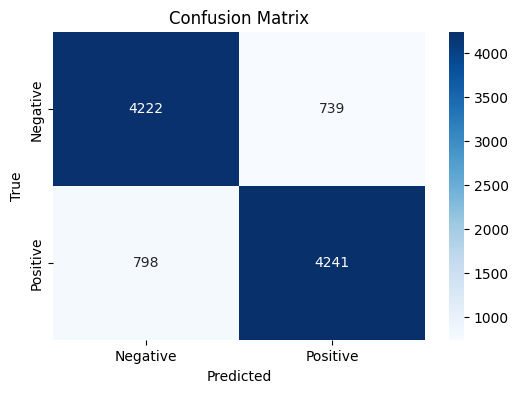

In [4]:
X = df['clean_review']
y = df['sentiment']

# Split into 80% train and 20% test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Create a Bag-of-Words representation
vectorizer = CountVectorizer(stop_words='english', max_features=5000)

X_train_bow = vectorizer.fit_transform(X_train)
X_test_bow = vectorizer.transform(X_test)

print(f"Shape of training data: {X_train_bow.shape}")

# Initialize the Multinomial Naïve Bayes model
nb_classifier = MultinomialNB()

# Train the model
nb_classifier.fit(X_train_bow, y_train)

# Predict on test set
y_pred = nb_classifier.predict(X_test_bow)

# Compute accuracy
accuracy = accuracy_score(y_test, y_pred)
print(f"Test Accuracy: {accuracy:.4f}")

# Classification report
print("\nClassification Report:")
print(classification_report(y_test, y_pred))

# Confusion matrix
cm = confusion_matrix(y_test, y_pred)

# Visualize confusion matrix
plt.figure(figsize=(6,4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Negative', 'Positive'],
            yticklabels=['Negative', 'Positive'])
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()



TF-IDF Test Accuracy: 0.8487

Classification Report (TF-IDF):
              precision    recall  f1-score   support

    Negative       0.85      0.84      0.85      4961
    Positive       0.85      0.85      0.85      5039

    accuracy                           0.85     10000
   macro avg       0.85      0.85      0.85     10000
weighted avg       0.85      0.85      0.85     10000



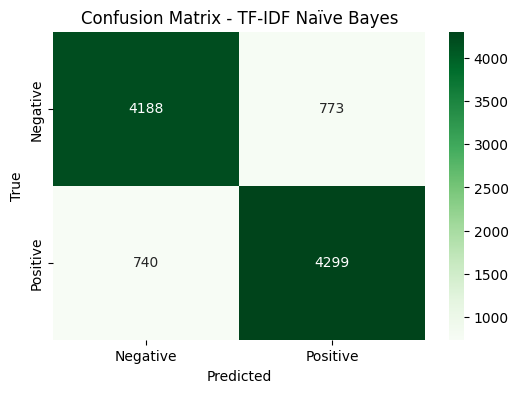

In [5]:
# TF-IDF representation (term frequency–inverse document frequency)
tfidf = TfidfVectorizer(stop_words='english', max_features=5000)
X_train_tfidf = tfidf.fit_transform(X_train)
X_test_tfidf = tfidf.transform(X_test)

# Train NB with TF-IDF
nb_tfidf = MultinomialNB()
nb_tfidf.fit(X_train_tfidf, y_train)

# Evaluate
y_pred_tfidf = nb_tfidf.predict(X_test_tfidf)
accuracy_tfidf = accuracy_score(y_test, y_pred_tfidf)
print(f"TF-IDF Test Accuracy: {accuracy_tfidf:.4f}")

# Classification Report
print("\nClassification Report (TF-IDF):")
print(classification_report(y_test, y_pred_tfidf, target_names=["Negative", "Positive"]))

# Confusion Matrix
cm_tfidf = confusion_matrix(y_test, y_pred_tfidf)

# Visualize Confusion Matrix
plt.figure(figsize=(6,4))
sns.heatmap(cm_tfidf, annot=True, fmt='d', cmap='Greens',
            xticklabels=['Negative', 'Positive'],
            yticklabels=['Negative', 'Positive'])
plt.title('Confusion Matrix - TF-IDF Naïve Bayes')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()



In [6]:
# ===============================
# 🧠 Text Sentiment Analysis Project
# Domain Adaptation | Model Comparison | Low-Data Learning
# Dataset: IMDB Movie Reviews
# ===============================

!pip install -q transformers datasets torch torchvision torchaudio scikit-learn matplotlib seaborn tqdm accelerate evaluate

import pandas as pd
import numpy as np
import torch
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from datasets import Dataset, DatasetDict
from transformers import (
    AutoTokenizer,
    AutoModelForSequenceClassification,
    TrainingArguments,
    Trainer,
)
import evaluate
from tqdm import tqdm

# -------------------------------------------------------------
# 2️⃣ Load and Explore IMDB Dataset
# -------------------------------------------------------------
df = pd.read_csv("data/IMDB Dataset.csv")

# Encode sentiment to numeric labels
df["label"] = df["sentiment"].map({"positive": 1, "negative": 0})
df = df.sample(frac=1, random_state=42).reset_index(drop=True)  # shuffle

# Split dataset
train_df, test_df = train_test_split(df, test_size=0.2, random_state=42, stratify=df["label"])
train_df, val_df = train_test_split(train_df, test_size=0.1, random_state=42, stratify=train_df["label"])

print(f"Train size: {len(train_df)}, Val size: {len(val_df)}, Test size: {len(test_df)}")

# Convert to Hugging Face Dataset format
train_ds = Dataset.from_pandas(train_df)
val_ds = Dataset.from_pandas(val_df)
test_ds = Dataset.from_pandas(test_df)
dataset = DatasetDict({"train": train_ds, "validation": val_ds, "test": test_ds})

# -------------------------------------------------------------
# 3️⃣ Subset Data (to improve speed)
# -------------------------------------------------------------
# ⚡ Use smaller subsets for faster experimentation
dataset_small = DatasetDict({
    "train": dataset["train"].select(range(3000)),        # 3k train
    "validation": dataset["validation"].select(range(1000)),  # 1k validation
    "test": dataset["test"].select(range(1000))           # 1k test
})
print(dataset_small)

# -------------------------------------------------------------
# 4️⃣ Tokenization
# -------------------------------------------------------------
checkpoint = "distilbert-base-uncased"
tokenizer = AutoTokenizer.from_pretrained(checkpoint)

def preprocess_function(batch):
    return tokenizer(batch["review"], truncation=True, padding="max_length", max_length=128)

tokenized_ds = dataset_small.map(preprocess_function, batched=True)
# Clean up extra columns safely
to_remove = [col for col in tokenized_ds["train"].column_names if col not in ["input_ids", "attention_mask", "label"]]
tokenized_ds = tokenized_ds.remove_columns(to_remove)
tokenized_ds.set_format("torch", columns=["input_ids", "attention_mask", "label"])

print(f"✅ Tokenization complete. Sample keys: {tokenized_ds['train'].column_names}")

# -------------------------------------------------------------
# 5️⃣ Define Evaluation Metrics
# -------------------------------------------------------------
accuracy = evaluate.load("accuracy")
f1 = evaluate.load("f1")

def compute_metrics(eval_pred):
    logits, labels = eval_pred
    preds = np.argmax(logits, axis=-1)
    acc = accuracy.compute(predictions=preds, references=labels)
    f1_score = f1.compute(predictions=preds, references=labels)
    return {"accuracy": acc["accuracy"], "f1": f1_score["f1"]}

# -------------------------------------------------------------
# 6️⃣ Model Comparison
# -------------------------------------------------------------
models_to_compare = [
    "distilbert-base-uncased",
    "bert-base-uncased",
    "roberta-base",
    "albert-base-v2",
]

results = []

for model_ckpt in models_to_compare:
    print(f"\n🚀 Training model: {model_ckpt}")

    # Load model
    model = AutoModelForSequenceClassification.from_pretrained(model_ckpt, num_labels=2)

    # Training setup
    args = TrainingArguments(
        output_dir=f"./results/{model_ckpt.split('/')[-1]}",
        eval_strategy="epoch",             # for transformers>=4.57.1
        save_strategy="epoch",
        learning_rate=2e-5,
        per_device_train_batch_size=8,
        per_device_eval_batch_size=8,
        num_train_epochs=1,                # quick comparison; use 2-3 for final run
        weight_decay=0.01,
        logging_dir="./logs",
        logging_strategy="epoch",
        load_best_model_at_end=True,
        report_to="none"                   # disable wandb
    )

    trainer = Trainer(
        model=model,
        args=args,
        train_dataset=tokenized_ds["train"],
        eval_dataset=tokenized_ds["validation"],
        tokenizer=tokenizer,
        compute_metrics=compute_metrics
    )

    trainer.train()
    eval_result = trainer.evaluate()

    results.append({
        "Model": model_ckpt,
        "Accuracy": eval_result["eval_accuracy"],
        "F1": eval_result["eval_f1"]
    })



[notice] A new release of pip is available: 23.1.2 -> 25.3
[notice] To update, run: python.exe -m pip install --upgrade pip
c:\Users\Jun Sheng\OneDrive\Desktop\SC4001\Assignment 2\.venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Train size: 36000, Val size: 4000, Test size: 10000
DatasetDict({
    train: Dataset({
        features: ['review', 'sentiment', 'label', '__index_level_0__'],
        num_rows: 3000
    })
    validation: Dataset({
        features: ['review', 'sentiment', 'label', '__index_level_0__'],
        num_rows: 1000
    })
    test: Dataset({
        features: ['review', 'sentiment', 'label', '__index_level_0__'],
        num_rows: 1000
    })
})


Map: 100%|██████████| 1000/1000 [00:00<00:00, 7257.18 examples/s]


✅ Tokenization complete. Sample keys: ['label', 'input_ids', 'attention_mask']

🚀 Training model: distilbert-base-uncased


Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
C:\Users\Jun Sheng\AppData\Local\Temp\ipykernel_14268\4286665183.py:121: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(
c:\Users\Jun Sheng\OneDrive\Desktop\SC4001\Assignment 2\.venv\Lib\site-packages\torch\utils\data\dataloader.py:668: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


Epoch,Training Loss,Validation Loss,Accuracy,F1
1,0.445300,0.416508,0.826000,0.832692


c:\Users\Jun Sheng\OneDrive\Desktop\SC4001\Assignment 2\.venv\Lib\site-packages\torch\utils\data\dataloader.py:668: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)



🚀 Training model: bert-base-uncased


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
C:\Users\Jun Sheng\AppData\Local\Temp\ipykernel_14268\4286665183.py:121: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(
c:\Users\Jun Sheng\OneDrive\Desktop\SC4001\Assignment 2\.venv\Lib\site-packages\torch\utils\data\dataloader.py:668: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


Epoch,Training Loss,Validation Loss,Accuracy,F1
1,0.414300,0.399198,0.851000,0.857960


c:\Users\Jun Sheng\OneDrive\Desktop\SC4001\Assignment 2\.venv\Lib\site-packages\torch\utils\data\dataloader.py:668: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)



🚀 Training model: roberta-base


c:\Users\Jun Sheng\OneDrive\Desktop\SC4001\Assignment 2\.venv\Lib\site-packages\huggingface_hub\file_download.py:143: UserWarning: `huggingface_hub` cache-system uses symlinks by default to efficiently store duplicated files but your machine does not support them in C:\Users\Jun Sheng\.cache\huggingface\hub\models--roberta-base. Caching files will still work but in a degraded version that might require more space on your disk. This warning can be disabled by setting the `HF_HUB_DISABLE_SYMLINKS_WARNING` environment variable. For more details, see https://huggingface.co/docs/huggingface_hub/how-to-cache#limitations.
To support symlinks on Windows, you either need to activate Developer Mode or to run Python as an administrator. In order to activate developer mode, see this article: https://docs.microsoft.com/en-us/windows/apps/get-started/enable-your-device-for-development
  warnings.warn(message)
Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling ba

Epoch,Training Loss,Validation Loss,Accuracy,F1
1,0.695700,0.693523,0.500000,0.000000


c:\Users\Jun Sheng\OneDrive\Desktop\SC4001\Assignment 2\.venv\Lib\site-packages\torch\utils\data\dataloader.py:668: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)



🚀 Training model: albert-base-v2


c:\Users\Jun Sheng\OneDrive\Desktop\SC4001\Assignment 2\.venv\Lib\site-packages\huggingface_hub\file_download.py:143: UserWarning: `huggingface_hub` cache-system uses symlinks by default to efficiently store duplicated files but your machine does not support them in C:\Users\Jun Sheng\.cache\huggingface\hub\models--albert-base-v2. Caching files will still work but in a degraded version that might require more space on your disk. This warning can be disabled by setting the `HF_HUB_DISABLE_SYMLINKS_WARNING` environment variable. For more details, see https://huggingface.co/docs/huggingface_hub/how-to-cache#limitations.
To support symlinks on Windows, you either need to activate Developer Mode or to run Python as an administrator. In order to activate developer mode, see this article: https://docs.microsoft.com/en-us/windows/apps/get-started/enable-your-device-for-development
  warnings.warn(message)
Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling 

Epoch,Training Loss,Validation Loss,Accuracy,F1
1,0.706400,0.693037,0.499000,0.665777


c:\Users\Jun Sheng\OneDrive\Desktop\SC4001\Assignment 2\.venv\Lib\site-packages\torch\utils\data\dataloader.py:668: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)



📊 Model Comparison Results:


,Model,Accuracy,F1
0,distilbert-base-uncased,0.826,0.832692
1,bert-base-uncased,0.851,0.857960
2,roberta-base,0.500,0.000000
3,albert-base-v2,0.499,0.665777


C:\Users\Jun Sheng\AppData\Local\Temp\ipykernel_14268\3781524906.py:10: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x="Model", y="Accuracy", data=results_df, palette="viridis")


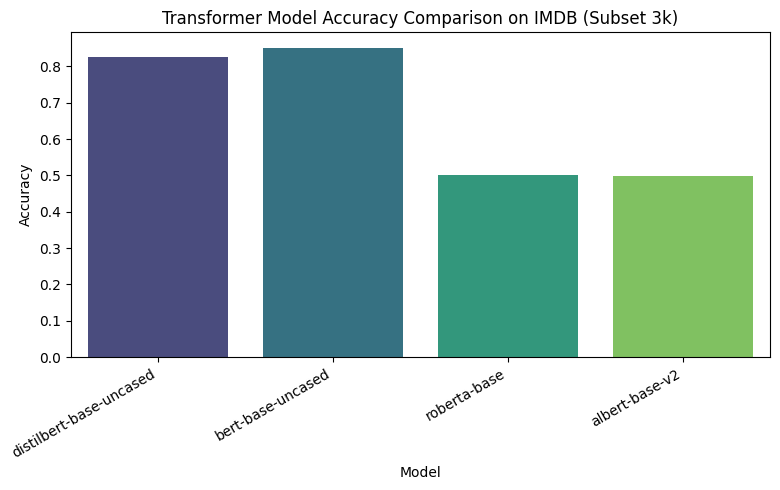

C:\Users\Jun Sheng\AppData\Local\Temp\ipykernel_14268\3781524906.py:20: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x="Model", y="F1", data=results_df, palette="mako")


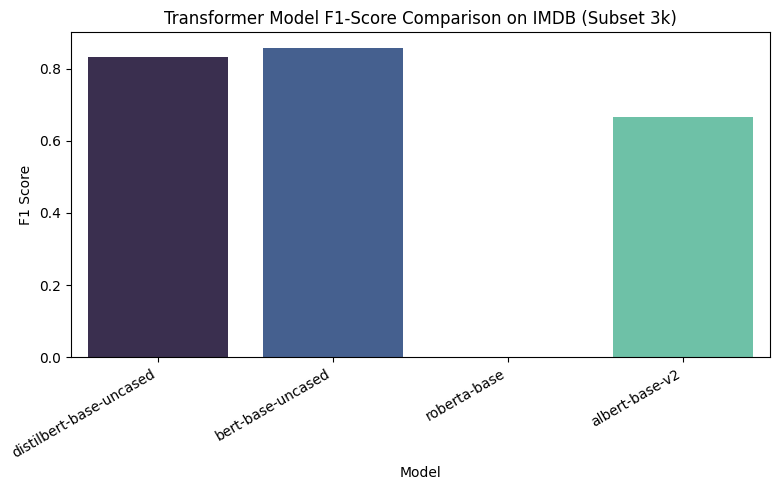

In [7]:
# -------------------------------------------------------------
# 7️⃣ Visualize and Compare Models
# -------------------------------------------------------------
results_df = pd.DataFrame(results)
print("\n📊 Model Comparison Results:")
display(results_df)

# Plot Accuracy Comparison
plt.figure(figsize=(8, 5))
sns.barplot(x="Model", y="Accuracy", data=results_df, palette="viridis")
plt.title("Transformer Model Accuracy Comparison on IMDB (Subset 3k)")
plt.xlabel("Model")
plt.ylabel("Accuracy")
plt.xticks(rotation=30, ha="right")
plt.tight_layout()
plt.show()

# Plot F1 Comparison
plt.figure(figsize=(8, 5))
sns.barplot(x="Model", y="F1", data=results_df, palette="mako")
plt.title("Transformer Model F1-Score Comparison on IMDB (Subset 3k)")
plt.xlabel("Model")
plt.ylabel("F1 Score")
plt.xticks(rotation=30, ha="right")
plt.tight_layout()
plt.show()


📈 Final Model Comparison:


,Model,Accuracy,F1
0,distilbert-base-uncased,0.826,0.832692
1,bert-base-uncased,0.851,0.857960
2,roberta-base,0.500,0.000000
3,albert-base-v2,0.499,0.665777


C:\Users\Jun Sheng\AppData\Local\Temp\ipykernel_14268\3492888570.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x="Model", y="Accuracy", data=results_df, palette="viridis")


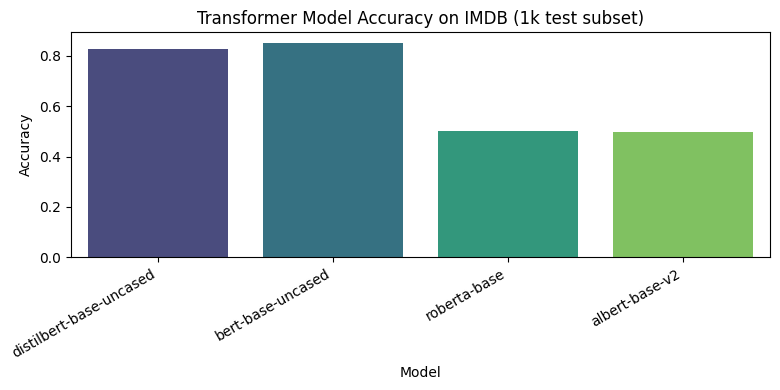

C:\Users\Jun Sheng\AppData\Local\Temp\ipykernel_14268\3492888570.py:13: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x="Model", y="F1", data=results_df, palette="mako")


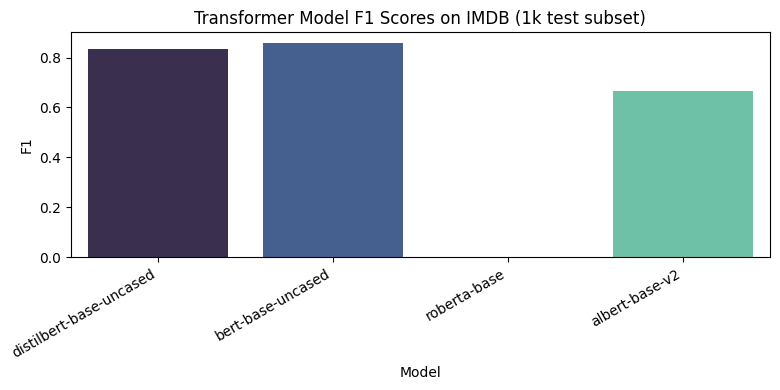

In [8]:
results_df = pd.DataFrame(results)
print("\n📈 Final Model Comparison:")
display(results_df)

plt.figure(figsize=(8,4))
sns.barplot(x="Model", y="Accuracy", data=results_df, palette="viridis")
plt.title("Transformer Model Accuracy on IMDB (1k test subset)")
plt.xticks(rotation=30, ha="right")
plt.tight_layout()
plt.show()

plt.figure(figsize=(8,4))
sns.barplot(x="Model", y="F1", data=results_df, palette="mako")
plt.title("Transformer Model F1 Scores on IMDB (1k test subset)")
plt.xticks(rotation=30, ha="right")
plt.tight_layout()
plt.show()

In [ ]:
# -------------------------------------------------------------
# 6️⃣ Domain Adaptation: IMDB → Yelp
# -------------------------------------------------------------
print("\n🌐 Domain Adaptation Experiment: IMDB → Yelp")

from datasets import load_dataset

yelp = load_dataset("yelp_polarity")

def preprocess_yelp(batch):
    return tokenizer(batch["text"], truncation=True, padding="max_length", max_length=128)

tokenized_yelp = yelp.map(preprocess_yelp, batched=True)

# Train on IMDB subset, test on Yelp
model = AutoModelForSequenceClassification.from_pretrained("distilbert-base-uncased", num_labels=2).to(device)

args = TrainingArguments(
    output_dir="./domain_adaptation",
    evaluation_strategy="epoch",
    learning_rate=2e-5,
    per_device_train_batch_size=8,
    per_device_eval_batch_size=8,
    num_train_epochs=2,
    weight_decay=0.01,
    load_best_model_at_end=True
)

trainer = Trainer(
    model=model,
    args=args,
    train_dataset=tokenized_ds["train"].select(range(5000)),
    eval_dataset=tokenized_yelp["test"].select(range(1000)),
    tokenizer=tokenizer,
    compute_metrics=compute_metrics
)

trainer.train()
domain_eval = trainer.evaluate()
print("\n📈 Domain Adaptation (IMDB → Yelp) Results:", domain_eval)

# -------------------------------------------------------------
# 7️⃣ Small Dataset Experiment
# -------------------------------------------------------------
print("\n📉 Small Dataset Experiment (Few-Shot Learning)")

small_train = tokenized_ds["train"].select(range(500))
small_val = tokenized_ds["validation"].select(range(200))

model = AutoModelForSequenceClassification.from_pretrained("distilbert-base-uncased", num_labels=2).to(device)

args = TrainingArguments(
    output_dir="./small_data",
    evaluation_strategy="epoch",
    learning_rate=3e-5,
    per_device_train_batch_size=8,
    num_train_epochs=5,
    weight_decay=0.01,
    load_best_model_at_end=True
)

trainer = Trainer(
    model=model,
    args=args,
    train_dataset=small_train,
    eval_dataset=small_val,
    tokenizer=tokenizer,
    compute_metrics=compute_metrics
)

trainer.train()
small_result = trainer.evaluate()
print("\n🧩 Small Dataset Results:", small_result)

# -------------------------------------------------------------
# 8️⃣ Model Evaluation and Visualization
# -------------------------------------------------------------
print("\n🔍 Evaluating on Full Test Set...")

preds_output = trainer.predict(tokenized_ds["test"].select(range(1000)))
preds = np.argmax(preds_output.predictions, axis=1)
labels = preds_output.label_ids

print("\nClassification Report:")
print(classification_report(labels, preds, target_names=["Negative", "Positive"]))

cm = confusion_matrix(labels, preds)
ConfusionMatrixDisplay(cm, display_labels=["Negative", "Positive"]).plot(cmap="Blues")
plt.title("Confusion Matrix (Few-Shot Model)")
plt.show()

# -------------------------------------------------------------
# 9️⃣ Sentiment Prediction Demo
# -------------------------------------------------------------
sentiment_pipe = pipeline("sentiment-analysis", model=trainer.model, tokenizer=tokenizer)
examples = [
    "I absolutely loved the cinematography and soundtrack!",
    "This movie was terrible, the plot made no sense.",
    "It was okay, not great but not awful either."
]
for text in examples:
    print(f"\n{text}")
    print(sentiment_pipe(text))